# Tarea 2 - MEL

Alejandro Mantilla - 201711304

Ximena Palacio - 201730995

## Índice

- [Parte A](#Parte-A.-Problemas-Computacionales.)

    - [Problema 1](#Problema-1.-Escriba-su-propia-función-para-hacer-pruebas-sobre-los-betas.)
    - [Problema 2](#Problema-2.-Visualizando-las-regiones-de-confianza.)

- [Parte B](#Parte-B.-Problemas-Teóricos-y-Conceptuales.)

    - [Problema 3](#Problema-3.-Formas-de-variables-dummies.)
    
- [Parte C](#Parte-C.-Problemas-Aplicados-con-Datos-Reales.)

    - [Problema 4](#Problema-4.-Modelos-No-Lineales.)
    - [Problema 5](#Problema-5.-Efectos-de-la-personalidad-en-la-producción-intelectual-bajo-estrés.)
    - [Problema 6](#Problema-6.-Interacciones-y-Multicolinealidad.)

## Parte A. Problemas Computacionales.

### Problema 1. Escriba su propia función para hacer pruebas sobre los betas.

Como ya lo vimos en clase, las pruebas $F$ para restricciones en los parámetros $\beta$ de la recta incluyen
la mayor parte de las pruebas que se pueden hacer sobre los modelos de regresión (significancia global,
significancia de cada variable, combinaciones lineales, etc).

Como habrá visto, la función `lm` de R no tiene la opción de inferir sobre restricciones generales, sino
que hace la prueba de significancia global y las individuales.

Lea el capítulo 10 del documento de introducción a R (`intro-R.pdf`) sobre cómo crear sus propias
funciones, y con esto:

#### 1. Cree su propia función para estimar un modelo de regresión lineal en donde los inputs son: matriz $X$, vector $Y$, el vector $c$, la matriz $A$ (si se quiere hacer una prueba general con restricciones) y el vector de subíndices que se quieren incluir en la hipótesis nula de una prueba de significancia parcial. Puede usar como base las funciones vistas en clase, si lo prefiere.

#### 2. La función debe tener una entrada binario en el que el usuario decide si quiere hacer una prueba con restricciones generales o una significancia parcial.

#### 3. La función debe dar como salida: la prueba de significancia global, las significancias individuales de cada uno de los betas (con pruebas de hipótesis o intervalos de confianza) y el resultado de la prueba asociada a $A$ o a los índices de los betas en la prueba parcial, incluyendo el _$p$-value_.

#### 4. Póngale el nombre de su preferencia a la función, añádale los demás atributos que quiera y úsela a su conveniencia.

Definimos la función, y la probamos a partir deun ejemplo sencillo con los datos de marketing del paquete `datarium`.

In [1]:
hipotesis_tests <- function(X, y, partial_tests = FALSE, indices = NULL, A = NULL, c = NULL) {

    if (partial_tests) {
        n <- nrow(X)
        p <- ncol(X)
        
        indices <- which(colnames(X) %in% c("facebook", "youtube"))
        
        q <- length(unique(indices))

        A <- diag(1, p)[indices, ]
        c <- matrix(rep(0, q), ncol = 1)
        
    } else {
        n <- nrow(X)
        p <- ncol(X)
        q <- nrow(A)
    }
    
    xtx <- t(X) %*% X
    H <- solve(xtx)

    beta_hat <- H %*% t(X) %*% y

    y_hat <- X %*% beta_hat

    s2 <- sum((y - y_hat) ^ 2) / (n - p)

    beta_r <- beta_hat +
              (H %*% t(A) %*% solve(A %*% H %*% t(A)) %*% (c -
                                                           (A %*% beta_hat)))

    ep <- (sum((y_hat - (X %*% beta_r)) ^ 2) / q) / s2

    pvalue <- 1 - pf(ep, q, (n - p))

    return(c(ep, pvalue))
}

In [2]:
data("marketing", package = "datarium")

X <- marketing[, c("youtube", "facebook", "newspaper")]
X <- as.matrix(cbind(1, X))
y <- as.matrix(marketing["sales"])

# Partial (facebook = youtube = 0):
hipotesis_tests(X = X, y = y, partial_tests = TRUE, indices = c("facebook", "youtube"))

# Compund (facebook = youtube):
A = matrix(c(0, 1, -1, 0), nrow = 1)
c = matrix(0)
hipotesis_tests(X, y, partial_tests = FALSE, A = A, c = c)


[1] 805.7141   0.0000

[1] 264.7242   0.0000

### Problema 2. Visualizando las regiones de confianza.

Hasta ahora sabemos hacer intervalos de confianza asociados a cada uno de los parámetros $\beta_{j}$ para $j = 0, 1, \cdots , k$. Sin embargo, estos están relacionados a pruebas individuales, con conjuntas. Para solucionar esto, vamos a hacer regiones conjuntas de confianza para pares de parámetros. Para esto, tenga en cuenta que cada par de estimadores $\hat{\beta}_{i}$ y $\hat{\beta}_{i}$ para $i, j \in \{0, . . . , k\}$ se distribuyen como un vector normal bivariado (revisar las propiedades de la distribución normal multivariada), Esto es:

$$
  \left( \hat{\beta}_{i}, \hat{\beta}_{i}\right)^{T} \sim \mathcal{N}_{2}\left(\left( \beta_{i}, \beta_{i}\right)^{T}, \sigma^{2}\textbf{W}_{ij}\right).
$$

Donde la matriz $\textbf{W}_{ij}$ corresponde a los elementos correspondientes a las varianza y covarianza, esto es:

$$
  \textbf{W}_{ij} =
  \begin{bmatrix}
    h_{ii} & h_{ij}\\
    h_{ij} & h_{jj}
  \end{bmatrix}.
$$

Para construir el la región de confianza siga los siguientes pasos:

#### 1. Determine la distribución de:

$$
  \sigma^{-1}\textbf{W}_{ij}^{-\frac{1}{2}}
  \begin{bmatrix}
    \hat{\beta}_{i} - \beta_{i}\\
    \hat{\beta}_{j} - \beta_{j}
  \end{bmatrix}
$$

Llegamos a la expresión deseada, estandarizando los estimadores. Estandarizar las distribuciones marginales también estandariza la distribución conjunta.

\begin{align*}
  \begin{bmatrix}
    \hat{\beta}_{i}\\
    \hat{\beta}_{j}
  \end{bmatrix} &\sim \mathcal{N}_{2}\left(
  \begin{bmatrix}
    \beta_{i}\\
    \beta_{j}
  \end{bmatrix}, \sigma^{2}\textbf{W}_{ij}\right) \\
  \begin{bmatrix}
    \hat{\beta}_{i} - \beta_{i} \\
    \hat{\beta}_{j} - \beta_{j}
  \end{bmatrix} &\sim \mathcal{N}_{2}\left(
  \begin{bmatrix}
    0\\
    0
  \end{bmatrix}, \sigma^{2}\textbf{W}_{ij}\right)
\end{align*}

$$
  \left[ \sigma^{2}\textbf{W}_{ij} \right]^{-\frac{1}{2}}
  \begin{bmatrix}
    \hat{\beta}_{i} - \beta_{i}\\
    \hat{\beta}_{j} - \beta_{j}
  \end{bmatrix}
  = \sigma^{-1}\textbf{W}_{ij}^{-\frac{1}{2}}
  \begin{bmatrix}
    \hat{\beta}_{i} - \beta_{i}\\
    \hat{\beta}_{j} - \beta_{j}
  \end{bmatrix}
  \sim \mathcal{N}_{2}\left(
  \begin{bmatrix}
    0\\
    0
  \end{bmatrix},
  \begin{bmatrix}
    1 & 0\\
    0 & 1
  \end{bmatrix}\right).
$$

La expresión se distribuye normal estándar bivariada.

#### 2. Determine la distribución de:

$$
  \sigma^{-2}
  \begin{bmatrix}
    \hat{\beta}_{i} - \beta_{i}\\
    \hat{\beta}_{j} - \beta_{j}
  \end{bmatrix}^{T}
  \textbf{W}_{ij}^{-1}
  \begin{bmatrix}
    \hat{\beta}_{i} - \beta_{i}\\
    \hat{\beta}_{j} - \beta_{j}
  \end{bmatrix}
$$

Usaremos la propiedad de simetría de la matriz $\textbf{W}_{ij}$: $\left[\textbf{W}_{ij}\right]^{T} = \textbf{W}_{ij}$.

Tomamos dos características que demostramos en la tarea anterior. Si $Y\sim\mathcal{N}(0,1)$, entonces:

-   $Y^{2}\sim\chi^{2}(1)$, y
-   $\sum_{i = 1}^{n}Y_{i}^{2}\sim\chi^{2}(n)$.

Por lo mismo, podemos ver que si $\begin{bmatrix} Y_{1} \\ Y_{2} \end{bmatrix} \sim \mathcal{N}_{2}(0,1)$, entonces:

$$
  \begin{bmatrix} Y_{1} \\ Y_{2} \end{bmatrix} ^{2} = \begin{bmatrix} Y_{1} & Y_{2} \end{bmatrix}\begin{bmatrix} Y_{1} \\ Y_{2} \end{bmatrix} = Y_{1}^{2} + Y_{2}^{2} = \sum_{i = 1}^{2} Y_{i}^{2} \sim \chi^{2}(2).
$$

La consecuencia de esta propiedad es que:

$$
  \left[\sigma^{-1}\textbf{W}_{ij}^{-\frac{1}{2}}
  \begin{bmatrix}
    \hat{\beta}_{i} - \beta_{i}\\
    \hat{\beta}_{j} - \beta_{j}
  \end{bmatrix}\right]^{2} \sim \chi^{2}(2).
$$

Desarrollamos esta propiedad hasta alcanzar la expresión deseada.


\begin{align*}
  \left[\sigma^{-1}\textbf{W}_{ij}^{-\frac{1}{2}}
  \begin{bmatrix}
    \hat{\beta}_{i} - \beta_{i}\\
    \hat{\beta}_{j} - \beta_{j}
  \end{bmatrix}\right]^{2} &=
  \left[\sigma^{-1}\textbf{W}_{ij}^{-\frac{1}{2}}
  \begin{bmatrix}
    \hat{\beta}_{i} - \beta_{i}\\
    \hat{\beta}_{j} - \beta_{j}
  \end{bmatrix}\right]^{T} \left[\sigma^{-1}\textbf{W}_{ij}^{-\frac{1}{2}}
  \begin{bmatrix}
    \hat{\beta}_{i} - \beta_{i}\\
    \hat{\beta}_{j} - \beta_{j}
  \end{bmatrix}\right] \\
  &= \sigma^{-2}
  \begin{bmatrix}
    \hat{\beta}_{i} - \beta_{i}\\
    \hat{\beta}_{j} - \beta_{j}
  \end{bmatrix}^{T} \left[\textbf{W}_{ij}^{-\frac{1}{2}}\right]^{T} \left[\textbf{W}_{ij}^{-\frac{1}{2}}
  \begin{bmatrix}
    \hat{\beta}_{i} - \beta_{i}\\
    \hat{\beta}_{j} - \beta_{j}
  \end{bmatrix}\right] \\
  &= \sigma^{-2}
  \begin{bmatrix}
    \hat{\beta}_{i} - \beta_{i}\\
    \hat{\beta}_{j} - \beta_{j}
  \end{bmatrix}^{T} \textbf{W}_{ij}^{-1}
  \begin{bmatrix}
    \hat{\beta}_{i} - \beta_{i}\\
    \hat{\beta}_{j} - \beta_{j}
  \end{bmatrix} \sim \chi^{2}(2).
\end{align*}

#### 3. Como la varianza del error ($\sigma^{2}$) no se conoce, determine la distribución de:

$$
  \left(\frac{1}{2\cdot MSE}\right)
  \begin{bmatrix}
    \hat{\beta}_{i} - \beta_{i}\\
    \hat{\beta}_{j} - \beta_{j}
  \end{bmatrix}^{T}
  \textbf{W}_{ij}^{-1}
  \begin{bmatrix}
    \hat{\beta}_{i} - \beta_{i}\\
    \hat{\beta}_{j} - \beta_{j}
  \end{bmatrix}
$$

Por el teorema de Cochran, $\frac{SSE}{\sigma^{2}}\sim\chi^{2}(n-2)$.

Sean $S_{1} \sim \chi^{2}(d_{1})$ y $S_{2} \sim \chi^{2}(d_{2})$, entonces $\frac{S_{1}/d_{1}}{S_{2}/d_{2}} \sim F(d_{1}, d_{2})$.

Construimos una distribución $F$ de la misma manera:

$$
  S_{1} := \sigma^{-2}
  \begin{bmatrix}
    \hat{\beta}_{i} - \beta_{i}\\
    \hat{\beta}_{j} - \beta_{j}
  \end{bmatrix}^{T} \textbf{W}_{ij}^{-1}
  \begin{bmatrix}
    \hat{\beta}_{i} - \beta_{i}\\
    \hat{\beta}_{j} - \beta_{j}
  \end{bmatrix}.\\
  S_{1}\sim \chi^{2}(2) \implies d_{1} = 2.
$$

$$
  S_{2} := \frac{SSE}{\sigma^{2}}. \\
  S_{2} \sim \chi^{2}(n-2) \Rightarrow d_{2} = n-2.
$$

$$
  \frac{\sigma^{-2}
  \begin{bmatrix}
    \hat{\beta}_{i} - \beta_{i}\\
    \hat{\beta}_{j} - \beta_{j}
  \end{bmatrix}^{T} \textbf{W}_{ij}^{-1}
  \begin{bmatrix}
    \hat{\beta}_{i} - \beta_{i}\\
    \hat{\beta}_{j} - \beta_{j}
  \end{bmatrix} / 2}{\frac{SSE}{\sigma^{2}} / (n-2)} \sim F(2, n-2).
$$

$$
  \frac{\sigma^{-2}
  \begin{bmatrix}
    \hat{\beta}_{i} - \beta_{i}\\
    \hat{\beta}_{j} - \beta_{j}
  \end{bmatrix}^{T} \textbf{W}_{ij}^{-1}
  \begin{bmatrix}
    \hat{\beta}_{i} - \beta_{i}\\
    \hat{\beta}_{j} - \beta_{j}
  \end{bmatrix} / 2}{\frac{SSE}{\sigma^{2}} / (n-2)} = 
  \frac{\begin{bmatrix}
    \hat{\beta}_{i} - \beta_{i}\\
    \hat{\beta}_{j} - \beta_{j}
  \end{bmatrix}^{T}
  \textbf{W}_{ij}^{-1}
  \begin{bmatrix}
    \hat{\beta}_{i} - \beta_{i}\\
    \hat{\beta}_{j} - \beta_{j}
  \end{bmatrix}}{2\cdot MSE}.
$$

#### 4. Use la expresión del numeral anterior para definir una región (en este caso una elipse) que forma una región bidimensional con una confianza de $1-\alpha$.

Suponemos un intervalo de confianza conjunto sobre el estadístico F de cola superior.

La expresión del literal anterior define la forma cuadrática:
\begin{align*}
  f\left(\beta_{i},\beta_{j}\right) &= \frac{\begin{bmatrix}
      \hat{\beta}_{i} - \beta_{i}\\
      \hat{\beta}_{j} - \beta_{j}
    \end{bmatrix}^{T}
    \textbf{W}_{ij}^{-1}
    \begin{bmatrix}
      \hat{\beta}_{i} - \beta_{i}\\
      \hat{\beta}_{j} - \beta_{j}
    \end{bmatrix}}{2\cdot MSE} \\ 
    &= \frac{h_{jj}\left( \hat{\beta}_{i} -\beta_{i}\right)^{2} - 2h_{ij}\left( \hat{\beta}_{i} -\beta_{i}\right)\left( \hat{\beta}_{j} -\beta_{j}\right) + h_{ii}\left( \hat{\beta}_{j} -\beta_{j}\right)^{2}}{2 \cdot (h_{ii}h_{jj}-h_{ij}^{2}) \cdot MSE} \\
\end{align*}

Si se acota de la siguiente manera, esta forma cuadrática describe una región que satisface el intervalo de confianza en forma de elipse:

$$
\frac{h_{jj}\left( \hat{\beta}_{i} -\beta_{i}\right)^{2} - 2h_{ij}\left( \hat{\beta}_{i} -\beta_{i}\right)\left( \hat{\beta}_{j} -\beta_{j}\right) + h_{ii}\left( \hat{\beta}_{j} -\beta_{j}\right)^{2}}{2 \cdot (h_{ii}h_{jj}-h_{ij}^{2}) \cdot MSE} \leq F_{1-\alpha}(2,n-2).
$$

Expandimos la forma cuadrática hasta llegar a la forma general: $ax^{2} + by^{2} + cxy + dx + ey + f \leq 0$. Esto nos va a permitir graficar la elipse de manera más sencilla ya que conoceerémos la longitud de sus ejes y cuanto espacio debería ocupar en el gráfico.

$$
  h_{jj}\left( \hat{\beta}_{i}^{2} - 2\hat{\beta}_{i}\beta_{i} + \beta_{i}^{2}\right) - 2h_{ij}\left( \hat{\beta}_{i}\hat{\beta}_{j} + \beta_{i}\beta_{j} - \hat{\beta}_{i}\beta_{j} - \hat{\beta}_{j}\beta_{i} \right) + h_{ii}\left( \hat{\beta}_{j}^{2} - 2\hat{\beta}_{j}\beta_{j} + \beta_{j}^{2}\right) \leq 2 \cdot (h_{ii}h_{jj}-h_{ij}^{2}) \cdot MSE \cdot F_{1-\alpha}(2,n-2)\\
  h_{jj}\beta_{i}^{2} + h_{ii}\beta_{j}^{2} - 2h_{ij}\beta_{i}\beta_{j} + \left(2h_{ij}\hat{\beta}_{j} - 2h_{jj}\hat{\beta}_{i}\right)\beta_{i} + \left(2h_{ij}\hat{\beta}_{i} - 2h_{ii}\hat{\beta}_{j}\right)\beta_{j} - 2h_{ij}\hat{\beta}_{i}\hat{\beta}_{j} + h_{jj}\hat{\beta}_{i}^{2} + h_{ii}\hat{\beta}_{j}^{2} - 2 \cdot (h_{ii}h_{jj}-h_{ij}^{2}) \cdot MSE \cdot F_{1-\alpha}(2,n-2) \leq 0.
$$

En esta región, $F_{1 - \alpha}(2,n-2)$ es el percentil para un porcentaje $\alpha$ de cola izquierda de una distribución $F(2,n-2)$.

#### 5 & 6. Investigue la función contour de R, y úsela para graficar la región (elipse) de confianza dados los valores $\hat{\beta}_{i}$, $\hat{\beta}_{j}$, $\textbf{W}_{ij}$ y el $MSE$. Puede usar cualquier otra función que considere pertinente para graficar. Cree una función donde los inputs son los datos X, Y, el nivel de significancia ($\alpha$) y el par de parámetros betas (por ejemplo $\beta_{1}$ y $\beta_{3}$). Como resultado de la función, se debe producir un gráfico con la elipse de confianza para los dos parámetros seleccionados.

In [3]:
# Los parámetros alpha y n son desconocidos y deberían ser registrados por el usuario.
# Sus valores por defecto son para poder correr la función con instancias de prueba.
ellipse_contour <- function(beta_hat_i, beta_hat_j, W_ij, MSE, alpha = 0.05, n = 1000){
  # Producimos los parámetros de la forma general de la elipse (a * x ^ 2 + b * y ^ 2 + c * x * y + d * x + e * y + f < 0).
  a <- W_ij[2, 2]
  b <- W_ij[1, 1]
  c <- -2*W_ij[1,2]
  d <- 2*W_ij[1,2]*beta_hat_j - 2*W_ij[2,2]*beta_hat_i
  e <- 2*W_ij[1,2]*beta_hat_i - 2*W_ij[1,1]*beta_hat_j
  f <- -2*W_ij[1,2]*beta_hat_i*beta_hat_j + W_ij[2,2]*beta_hat_i^2 + W_ij[1,1]*beta_hat_j^2 - 2*(W_ij[1,1]*W_ij[2,2] - W_ij[1,2]^2) * MSE * qf(1-alpha, 2, n-2)

  # Definimos una función que grafica elipses a partir de sus parámetros.
  plot.ellipse <- function (a, b, c, d, e, f, n) {
    ## solve for centre
    A <- matrix(c(a, c / 2, c / 2, b), 2L)
    B <- c(-d / 2, -e / 2)
    mu <- solve(A, B)
    ## generate points on circle
    r <- sqrt(a * mu[1] ^ 2 + b * mu[2] ^ 2 + c * mu[1] * mu[2] - f)
    theta <- seq(0, 2 * pi, length = n)
    v <- rbind(r * cos(theta), r * sin(theta))
    ## transform for points on ellipse
    z <- backsolve(chol(A), v) + mu
    ## plot points
    plot(t(z), type = "l")
  }

  # Graficamos la elipse.
  plot.ellipse(a, b, c, d, e, f, n)
}

Hacemos un ejemplo sencillo con los datos de marketing del paquete `datarium`. Para estos datos vamos a computar la matriz de covarianzas de los beta seleccionados y el MSE del modelo. Haremos este procedimiento según los lineamientos del literal 6.

In [4]:
data("marketing", package = "datarium")
head(marketing)
X <- marketing[, c("youtube", "facebook", "newspaper")]
y <- marketing["sales"]

,youtube,facebook,newspaper,sales
,<dbl>,<dbl>,<dbl>,<dbl>
1,276.12,45.36,83.04,26.52
2,53.40,47.16,54.12,12.48
3,20.64,55.08,83.16,11.16
4,181.80,49.56,70.20,22.20
5,216.96,12.96,70.08,15.48
6,10.44,58.68,90.00,8.64


Crearemos una función que reciba estos datos, calcule los valores necesarios y llame a la función `ellipse_contour` que creamos antes.

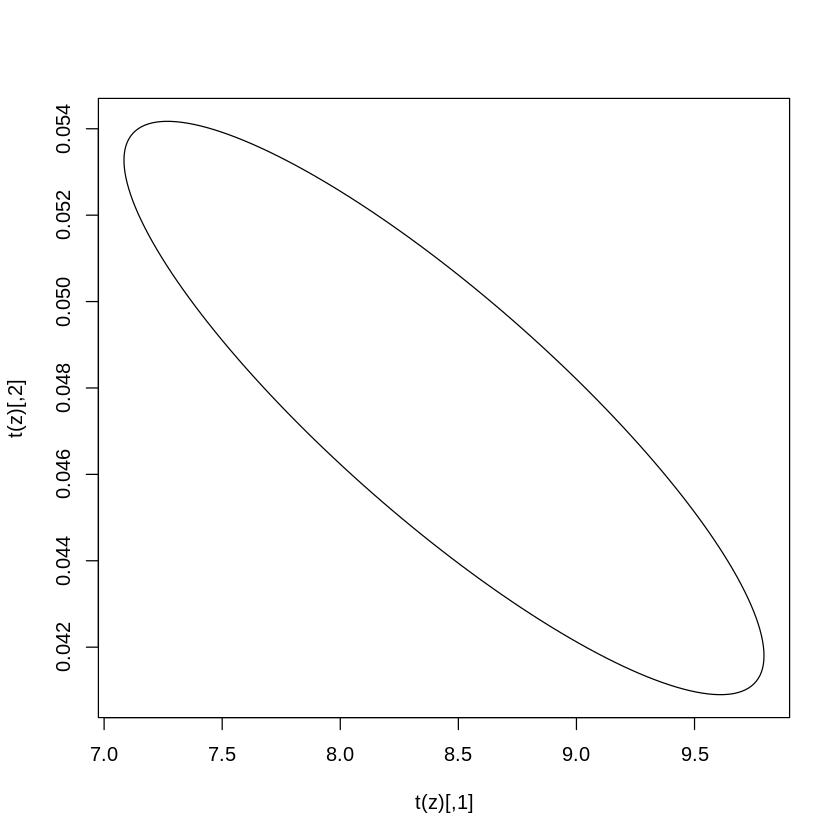

In [5]:
# Los parámetros beta_index_1 y beta_index_2 son enteros
# de 0 a k, con k cantidad de variables.
ellipse_from_data <- function(X, y, alpha = 0.05, beta_index_1, beta_index_2){
  X <- as.matrix(cbind(intercept = 1, X))
  X <- X[,c(beta_index_1, beta_index_2)]
  y <- as.matrix(y)
  n <- length(y)
  cov.mat <- solve(t(X) %*% X)
  coeff <- cov.mat %*% t(X) %*% y
  MSE <- sum((X %*% coeff - y) ^ 2) / (n - 2)
  ellipse_contour(coeff[1], coeff[2], cov.mat, MSE, alpha, n)
}

ellipse_from_data(X, y, 0.05, 1, 2)

## Parte B. Problemas Teóricos y Conceptuales.

### Problema 3. Formas de variables dummies.

Lo primero que se debe hacer es plantear el modelo utilizando los datos de `Carseats`.
$$x_1 = \ {Income} $$
$$x_2 = \ {Advertising} $$
$$z = \ {ShelveLoc} $$

Dado que la variable $z$ es una variable catergótica, el modelo tiene multicolinealidad y por ende no se puese estimar por lo que se debe utilizar una clase base. Para efectos de este punto se pide que se utilice la parametrización con restricción de suma cero. 
Para lo anterior se utiliza como blase base "bad" y la codificación quedaría de la siguiente manera: 

$$
z_m={1 \ \textit{caso de posición 'medium'} \\
      \frac{-n_m}{n_b} \ \textit{caso de posición'bad'} \\
      0 \ {dlc}}
$$

$$
z_g={1 \ \textit{caso de posición 'good'} \\
      \frac{-n_g}{n_b} \ \textit{caso de posición'bad'} \\
      0 \ {dlc}}
$$

Teniendo en cuenta las restricciones se considera el siguiente modelo con todas las dummies y todas las interacciones:

$$
y=\beta_0 + \beta_1 x_1 +\beta_2 x_2 + \tau_1 z_m + \tau_2 z_g +\gamma_1 x_1 z_m +\gamma_2 x_1 z_g +\gamma_3 x_2 z_m ++\gamma_4 x_2 z_g + \epsilon
$$


In [6]:
#PUNTO 3
library(psych)
library(ISLR)

data <- Carseats
?Carseats

#Frecuencia
nm <- table(data$ShelveLoc)[3]
ng <- table(data$ShelveLoc)[2]
nb <- table(data$ShelveLoc)[1]

#Variables dummies
zm <- ifelse(data$ShelveLoc == "Medium", 1,ifelse(data$ShelveLoc == "Bad",-(nm/nb),0))
zg <- ifelse(data$ShelveLoc == "Good", 1,ifelse(data$ShelveLoc == "Bad",-(ng/nb),0))

#Modelo
y <- data$Sales
x1 <- data$Income
x2 <- data$Advertising
x1xzm <- x1 * zm
x1xzg <- x1 * zg
x2xzm <- x2 * zm
x2xzg <- x2 * zg

x<-cbind(x1, x2, zm, zg, x1xzm, x1xzg, x2xzm, x2xzg)
regresion<-lm(y~x1+x2+zm+zg+x1xzm+x1xzg+x2xzm+x2xzg)
summary(regresion)  


Call:
lm(formula = y ~ x1 + x2 + zm + zg + x1xzm + x1xzg + x2xzm + 
    x2xzg)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.1411 -1.6175  0.0447  1.5514  6.3020 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.717157   0.308247  18.547  < 2e-16 ***
x1           0.016629   0.003967   4.192 3.42e-05 ***
x2           0.095648   0.016672   5.737 1.93e-08 ***
zm          -0.436735   0.281770  -1.550    0.122    
zg           3.289884   0.595522   5.524 6.05e-08 ***
x1xzm        0.003513   0.003618   0.971    0.332    
x1xzg       -0.010079   0.007563  -1.333    0.183    
x2xzm        0.006748   0.015179   0.445    0.657    
x2xzg        0.007940   0.031565   0.252    0.802    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.203 on 391 degrees of freedom
Multiple R-squared:  0.4035,	Adjusted R-squared:  0.3913 
F-statistic: 33.06 on 8 and 391 DF,  p-value: < 2.2e-16


#### 1. ¿Es cierto que la posición en el estante no infuye sobre las ventas?

Para poder saber sí la posición del estante no influye en las ventas se plantea la siguiente prueba de hipótesis
$$
H_0:\tau_1 = \tau_2 = \gamma_1 = \gamma_2 = \gamma_3 = \gamma_4 = 0 
$$

$$
H_1: \tau_1 \neq 0 \ \  or \ \ \tau_2 \neq 0 \ \ or \ \ \gamma_1 \neq 0 \ \ or \ \ \gamma_2 \neq 0 \ \ or \ \ \gamma_3 \neq 0 \ \ or \ \ \gamma_4 \neq 0 \ \ 
$$

In [8]:
gtest <- function(x,y,A,c){
  n <- length(y)
  k <- dim(x)[2]
  p <- k + 1
  q <- dim(A)[1]
  xx <- cbind(rep(1,n), x)
  beta <- solve(t(xx) %*% xx) %*% t(xx) %*% y
  yhat <- xx %*% beta  
  mse <- sum((y - yhat)^2)/(n - p)
  betaH <- beta + solve(t(xx) %*% xx) %*% t(A) %*% solve(A %*% solve(t(xx) %*% xx) %*% t(A)) %*% (c- A %*% beta)
  yhatH <- xx %*% betaH
  F <- (sum((y- yhatH)^2)-sum((y- yhat)^2))/q /mse
  pval <- 1-pf(F, q, n- p)
  return(list(F = F, pvalue = pval))
}

A <- matrix(c(0,0,0,1,0,0,0,0,0,
             0,0,0,0,1,0,0,0,0,
             0,0,0,0,0,1,0,0,0,
             0,0,0,0,0,0,1,0,0,
             0,0,0,0,0,0,0,1,0,
             0,0,0,0,0,0,0,0,1),ncol=9,byrow = T)     
     
c <-c(0,0,0,0,0,0)

gtest(x,y,A,c)

$F
[1] 34.12019

$pvalue
[1] 0

Con un nivel de confianza del 95% se puede concluir que se rechaza $H_0$, es decir que al menos una posición en el estante sí influye en las ventas. Pues el ${p value}<5 \% $ 

#### 2. ¿Es cierto que los modelos en todas las clases son paralelos (los efectos no cambian)?

Para poder saber si los modelos en todas las clases son paralelos, es decir que sus efectos no cambian se plantea la siguiente prueba de hipótesis 


$$
H_0:\gamma_1 = \gamma_2 = \gamma_3 = \gamma_4 = 0 
$$

$$
H_1:\gamma_1 \neq 0 \ \ or \ \ \gamma_2 \neq 0 \ \ or \ \ \gamma_3 \neq 0 \ \ or \ \ \gamma_4 \neq 0 \ \ 
$$

In [11]:
A <- matrix(c(0,0,0,0,0,1,0,0,0,
             0,0,0,0,0,0,1,0,0,
             0,0,0,0,0,0,0,1,0,
             0,0,0,0,0,0,0,0,1),
           ncol=9,byrow = T)


c <- c(0,0,0,0)

gtest(x,y,A,c)

$F
[1] 0.6020059

$pvalue
[1] 0.6614046

Con un nivel de confianza del 95% se puede concluir que se no hay suficiente evidencia estadística para rechazar $H_0$, es decir que el modelo en todas sus clases es pararelo, es decir que en se puede afirmar que sus efectos no cambian, pues el ${p value}>5 \% $ 

#### 3. ¿Son los modelos para las ventas posición media en el estante, y para la posición buena iguales?

Para poder saber si los modelos para las ventas en la posicipon media del estante y la posición buena del estante son iguales, se plantea la siguiente prueba de hipótesis 

$$
    \ H_0 =
        \begin{bmatrix}
            \tau_1 = \tau_2\\
            \gamma_1 =  \gamma_2\\
            \gamma_3 =  \gamma_4\\
        \end{bmatrix}
$$

$$
H_1:\textit{Al menos una es diferente}
$$

In [10]:
A <- matrix(c(0,0,0,-1,1,0,0,0,0,
             0,0,0,0,0,-1,1,0,0,
             0,0,0,0,0,0,0,-1,1),ncol=9,byrow = T)
c <- c(0,0,0)

gtest(x,y,A,c)



$F
[1] 33.79128

$pvalue
[1] 0

Con un nivel de confianza del 95% se puede concluir que se rechaza $H_0$, es decir que los modelos no son iguales. La posición media en el estante puede ser igual a la posición buena en el estante por lo menos para algún caso. Pues el ${p value}<5 \% $ 

#### 4. ¿Es cierto que el efecto de la publicidad es igual en la posición mala que en la media?

Para poder saber si el efecto de la publicidad es igual en la posición mala que en la media, se utiliza el coeficiente $\gamma_3$ que corresponde a la interacción entre la publicidad y la posición media y en la prueba de hipótesis queremos ver si este coeficiente es igual a 0 (no se ve la interacción con la posición mala pues esta es nuestra clase base). La prueba de hipotesis sería:

$$
H_0: \gamma_3 =  0
$$

$$
H_1:\gamma_3 \neq 0
$$

In [12]:
A <- matrix(c(0,0,0,0,0,0,0,1,0),ncol=9,byrow = T)
c <-c(0)

gtest(x,y,A,c)


$F
[1] 0.1976097

$pvalue
[1] 0.6569032

In [13]:
#Otra forma para comparar
ltest=function(y,x,lin,const,dir=b){
  n=dim(x)[1]
  k=dim(x)[2]
  p=k+1
  xx=cbind(rep(1,n),x)
  beta=solve(t(xx)%*%xx)%*%t(xx)%*%y
  A=matrix(lin,ncol=p)
  c=const
  t=sign(A%*%lin-c)*sqrt(gtest(x,y,A,c)$F)  
  if(dir=="+"){pval=1-pt(t,n-p)}
  if(dir=="-"){pval=pt(t,n-p)}
  if(dir=="b"){pval=min(2*(1-pt(t,n-p)),2*(pt(t,n-p)))}
  return(list(t=t,pvalue=pval))
}

lin <- c(0,0,0,0,0,0,0,1,0)
ltest(y,x,lin,0,"b")



0.4445331


Con un nivel de confianza del 95% se puede concluir que se no hay suficiente evidencia estadística para rechazar $H_0$, es decir que el efecto de la publicidad para la posición mala es igual que para la posición media, pues el ${p value}>5 \% $, e incluso es exactamente el mismo valor haciendolo con una prueba $F$ o con una prueba parcial $t$.

## Parte C. Problemas Aplicados con Datos Reales.

### Problema 4. Modelos No-Lineales.

### Problema 5. Efectos de la personalidad en la producción intelectual bajo estrés.

### Problema 6. Interacciones y Multicolinealidad.